As modern vehicles have lots of connectivity, protecting in-vehicle network from cyber-attacks is an important issue. Controller Area Network (CAN) is the de facto standard for the in-vehicle network. But, the lack of security features in the CAN protocol makes vehicles vulnerable to attacks. The message injection attack is a representative attack type which injects fabricated messages to deceive electronic control unit (ECUs) or cause malfunctions. 

### Source
The dataset (CAN-intrusion-dataset-10000.csv) has been constructed by logging CAN traffic via the OBD-II port from a real vehicle while message injection attacks were performing. The classification goal is to distinguish different types attacks and normal samples by classifying the data samples. The dataset includes over 10,000 records and 10 attributes.

### Variables
The definitions of the attributes are as follows.

* CAN ID : identifier of CAN message in HEX (ex. 043f).
* DATA[0~7] : data value (byte), ranging from 0 to 255. They have been converted from hexadecimal numbers to decimal numbers.  
* Label : 0 indicates 'Normal', and 1 indicates an attack or an attack type (including DoS, Fuzzy, Gear, or RPM).

In [2]:
## perform the necessary imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, make_scorer, confusion_matrix, roc_curve, auc, accuracy_score, f1_score, roc_auc_score
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from xgboost import XGBClassifier
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import torch

# Plotting
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import warnings 
warnings.filterwarnings('ignore')

Load the Data set CAN-intrusion-dataset-10000.csv 


In [3]:
data = pd.read_csv('CAN-intrusion-dataset-10000.csv')

In [4]:
X = data.drop(['Label'], axis=1)
y = data['Label']
# Split into equal sized training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
data.head()

,CAN_ID,DATA_0,DATA_1,DATA_2,DATA_3,DATA_4,DATA_5,DATA_6,DATA_7,Label
0,305,0,128,0,0,85,127,4,167,0
1,339,0,33,16,255,0,255,0,0,0
2,704,20,0,0,0,0,0,0,0,0
3,339,0,33,16,255,0,255,0,0,0
4,1072,0,0,0,0,0,0,0,0,0


In [5]:
print(X_train.shape[0], "observations in training set")
print("Class breakdown:")
print(y.value_counts())

5000 observations in training set
Class breakdown:
0    8580
1    1420
Name: Label, dtype: int64




* Build a model (L1 regularization) that predicts the attack. To get full points, implement the model in a pipeline
* Vary the regularization parameter  ðœ†  between 0.1 and 250, evenly spaced in log-space.
* Apply the necessary preprocessing steps to your variables
* Fit the model using an appropriate loss function
* Plot the coefficient path, i.e., the size of the regression coefficients relative to the size of the the regularization paramter. 

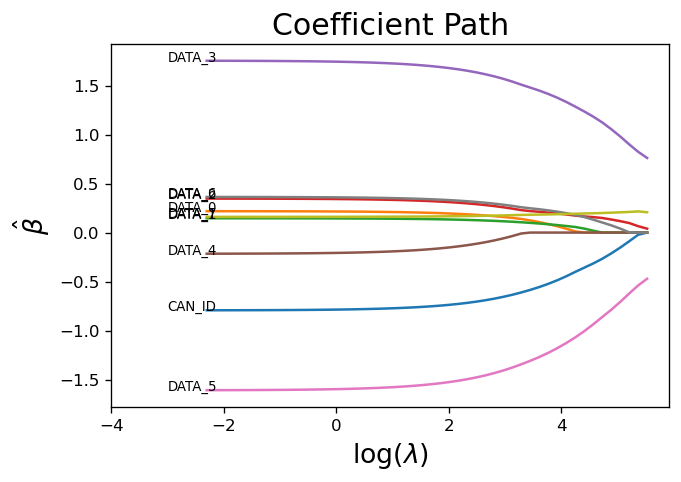

In [6]:
regularization_strength = np.exp(np.linspace(np.log(0.1),np.log(250),50))

coefs = np.zeros((regularization_strength.size, X.shape[1]))

for i,L in enumerate(regularization_strength):
    lasso_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('logistic_regression', LogisticRegression(penalty = 'l1', 
                                               solver='liblinear', 
                                               max_iter=10000,
                                               C = 1.0/L))
    ])
    
    lasso_pipe.fit(X, y)
    coefs[i] = lasso_pipe.named_steps['logistic_regression'].coef_    

fig, ax = plt.subplots(dpi = 120)
ax.plot(np.log(regularization_strength), coefs)
ax.set_xlabel(r'$\log(\lambda)$', fontsize = 16)
ax.set_ylabel(r'$\hat{\beta}$', fontsize = 16)
ax.set_title('Coefficient Path', fontsize = 18)
ax.set_xlim(-4,None)
for i, name in enumerate(data.columns[:-1]):
    ax.annotate(name, xy = (-3, coefs[0,i]), ha = 'left', fontsize = 8)

The most important variable is DATA_3, and the least important is DATA_4.

A plot of the crossvalidated log-likelihood against $log(\lambda)$. 


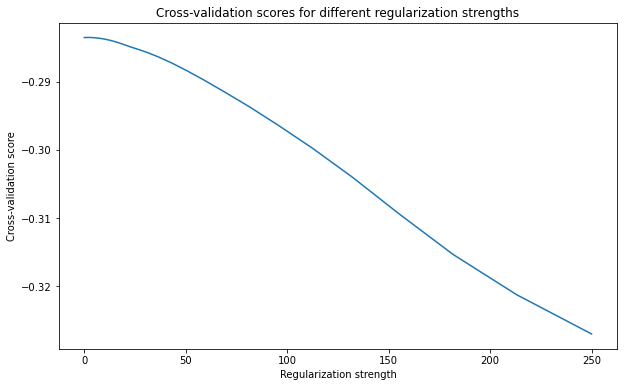

In [7]:
cv_scores = np.zeros(regularization_strength.size)

for i,L in enumerate(regularization_strength):
    lasso_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('logistic_regression', LogisticRegression(penalty = 'l1', 
                                               solver='liblinear', 
                                               max_iter=10000,
                                               C = 1.0/L)) # Note, C = 1/lambda
    ])
    
    cv_scores[i] = np.mean(cross_val_score(lasso_pipe, X, y, cv=10, scoring='neg_log_loss'))

# Plot the cross-validation scores
plt.figure(figsize=(10,6))
plt.plot(regularization_strength, cv_scores)
plt.xlabel('Regularization strength')
plt.ylabel('Cross-validation score')
plt.title('Cross-validation scores for different regularization strengths')
plt.show()


In [7]:
bestI=np.argmax(cv_scores)
print('Best lambda:',regularization_strength[bestI])
print('Variables included:',data.drop('Label', axis='columns').columns[coefs[bestI]!=0])


Best lambda: 2.0776317562572593
Variables included: Index(['CAN_ID', 'DATA_0', 'DATA_1', 'DATA_2', 'DATA_3', 'DATA_4', 'DATA_5',
       'DATA_6', 'DATA_7'],
      dtype='object')


The best value for the regularization parameter is 2.077631, and we should include all of the variables.

Plot the ROC curve for the test set and model.

Report the area under the ROC curve. 

Area under the curve:  0.8533595302484722


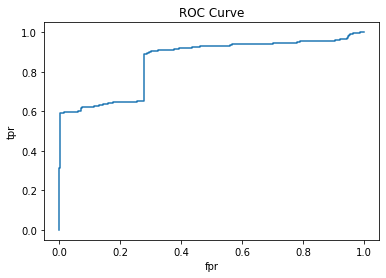

In [8]:
# Plot ROC Curve
lasso_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('logistic_regression', LogisticRegression(penalty = 'l1',
                                                  solver='liblinear',   
                                                    max_iter=10000,
                                                    C = 1.0/regularization_strength[bestI]))
])

lasso_pipe.fit(X_train, y_train)

y_pred = lasso_pipe.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)

plt.title("ROC Curve")
plt.xlabel("fpr")
plt.ylabel("tpr")
area_under_curve = auc(fpr, tpr)
print("Area under the curve: ", area_under_curve)

Area under curve: 0.853359

Achive a sensitivity of more than 0.85.

In [9]:
spec = 1-np.min(fpr[tpr>0.85])
print('The specificity is ', np.round(spec,4))

The specificity is  0.7214


In [10]:
conf_int = np.percentile(fpr[tpr>0.8], [5,95])
print("Conf Interval: ", conf_int) # Don't think this is right

Conf Interval:  [0.29988421 0.97313571]


**XGBoos vs. Random Forest**

In general, both models use the diversity in the sampling to create a deep space search. However, Random Forests is much more stringent on how much diversity we can extract from the data, as it requires sampling variables and cases simultaneously and learning more complex trees from such division. XGBoosting, on the other hand, usually samples only cases and learns from the deflated errors (as defined by the learning rate) of the previous steps. This has been empirically shown to work better on smaller samples with limited variables, such as the ones we have available in this project. So, XGB is at first look a better alternative for this problem.

In [8]:
max_depth = 3
learning_rate = [0.01, 0.1]
n_estimators = [50, 200]
seed = 20211217

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=300, random_state=seed)

In [9]:
param_grid = {
    'max_depth': [max_depth],
    'learning_rate': learning_rate,
    'n_estimators': n_estimators
}

In [10]:
est = XGBClassifier(eval_metric='logloss', use_label_encoder=False)

grid_search = GridSearchCV(
    refit=True,
    estimator=est,
    param_grid=param_grid,
    scoring='neg_log_loss',
    cv=5,
    n_jobs=2,
    verbose=4
)

In [11]:
# Best estimator and best parameters
grid_search.fit(X_train, y_train)
best_estimator = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best parameters: ", best_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


In [12]:
model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=np.NaN,
              monotone_constraints='()', n_estimators=200, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

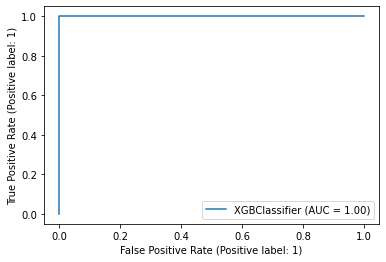

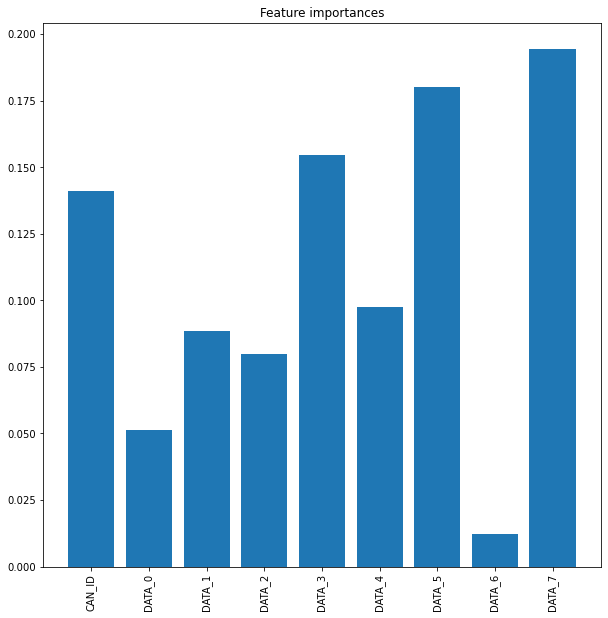

In [13]:
from sklearn.metrics import plot_roc_curve
model.fit(X_train, y_train)
# Try on the test set
y_pred = model.predict(X_test)
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plot_roc_curve(model, X_test, y_test)
importances = model.feature_importances_
# Plot importances
plt.figure(figsize=(10, 10))
plt.title("Feature importances")
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)), X.columns, rotation=90)
plt.show()


If the AUC of 1 is correct, which it probably isnt, then the model is perfect. Either XGBoost is a very good algoritham for this use case or I am missing somthing in the AUC.

**Not Normalizing data can cause variables of larger magnitudes to excert more effect on the formation of clusters. Normalizing these values allow smaller magnitude values to exert more of an effect on the clustering process relative to before the normalization.**

In [17]:
X = data.drop(['Label'], axis=1)
y = data['Label']
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

For n_clusters = 2 The average silhouette_score is : 0.4736333060416277
For n_clusters = 3 The average silhouette_score is : 0.4176367885690455
For n_clusters = 4 The average silhouette_score is : 0.4163078284489522
For n_clusters = 5 The average silhouette_score is : 0.40965746521949814
For n_clusters = 6 The average silhouette_score is : 0.4426644258042171
For n_clusters = 7 The average silhouette_score is : 0.4114130058511562


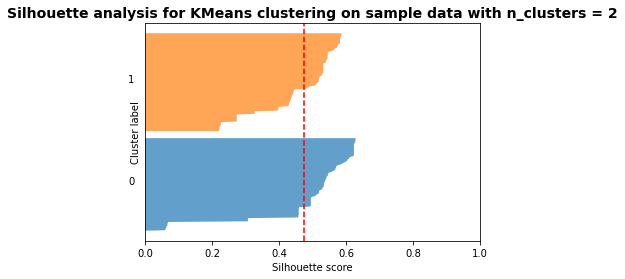

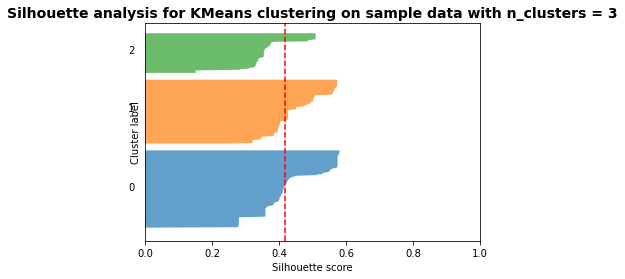

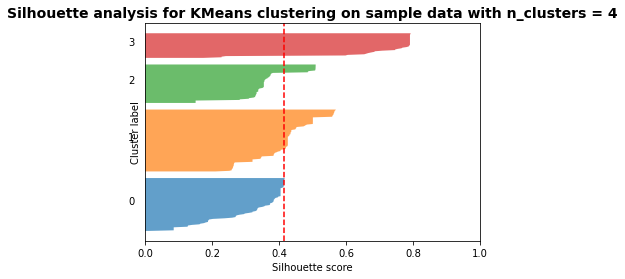

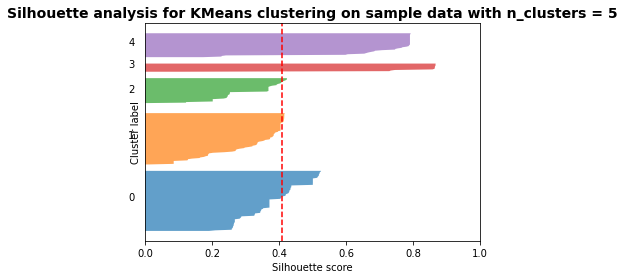

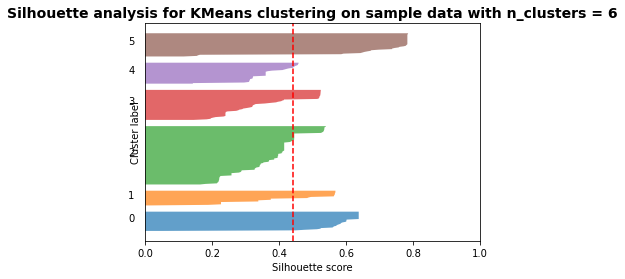

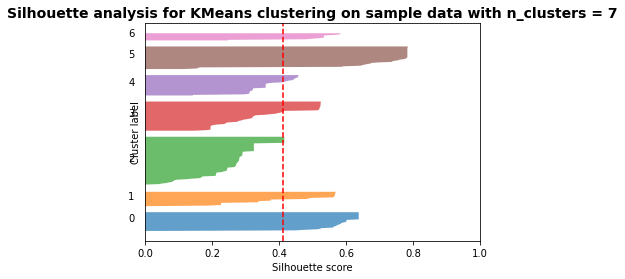

In [18]:
# MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

possible_ks = [2,3,4,5,6,7]
seed = 20211231

for cluster in possible_ks:
    model = KMeans(n_clusters=cluster, random_state=seed)
    model.fit(X_train)
    y_pred = model.predict(X_test)

    silhouette_avg = silhouette_score(X_test, y_pred)
    print("For n_clusters =", cluster, "The average silhouette_score is :", silhouette_avg)
    
    fig, ax = plt.subplots(1, 1)
    ax.set_xlim([0, 1])
    sample_silhouette_values = silhouette_samples(X_test, y_pred)
    
    
    y_lower = 10
    for i in range(cluster):

        ith_cluster_silhouette_values = \
            sample_silhouette_values[y_pred == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                           alpha=0.7)

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    plt.title(("Silhouette analysis for KMeans clustering on sample data "
                    "with n_clusters = %d" % cluster),
                    fontsize=14, fontweight='bold')   
    ax.set_xlabel("Silhouette score")
    ax.set_ylabel("Cluster label")

    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])
    ax.set_xticks([ 0, 0.2, 0.4, 0.6, 0.8, 1])  

Use 3 clusters. When k exceeds three, there starts to be some variation as well as clusters that are below the average.

Deep Learning Test

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

class LinearModel(torch.nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.dense1 = torch.nn.Linear(9, 2)
        self.activation = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.dense1(x)
        x = self.activation(x)
        return x
    
model = LinearModel()

# Z-standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Cross entropy loss function
criterion = torch.nn.CrossEntropyLoss()

# SGD, lr=0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

num_epochs = 10000

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train)
X_test_testor = torch.FloatTensor(X_test_scaled)

lossrecord = []


Text(0.5, 1.0, 'Loss vs. Epoch')

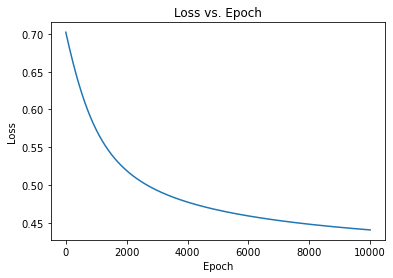

In [16]:
#Run the iterations
for epoch in range(num_epochs):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(X_train_tensor)

    # Compute and print loss.
    loss = criterion(y_pred, y_train_tensor)
    lossrecord.append(loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Plot
plt.plot(lossrecord)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')

In [17]:
y_pred = model(torch.FloatTensor(X_test_scaled)).detach().numpy()
y_pred = np.argmax(y_pred, axis=1)
# Get ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
# Get AUC
auc = roc_auc_score(y_test, y_pred)

print("AUC: %.3f" % auc)

AUC: 0.650


Text(0.5, 1.0, 'Loss vs. Epoch')

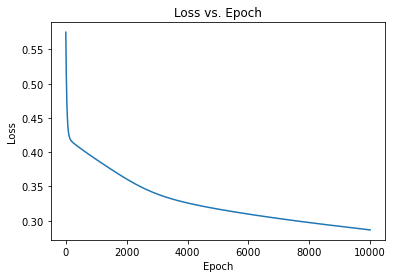

In [18]:
class NonLinearModel(torch.nn.Module):
    def __init__(self):
        super(NonLinearModel, self).__init__()
        self.dense1 = torch.nn.Linear(9, 50)
        self.activation1 = torch.nn.Sigmoid()
        self.dense2 = torch.nn.Linear(50, 2)
        self.activation2 = torch.nn.LogSigmoid()

    def forward(self, x):
        x = self.dense1(x)
        x = self.activation1(x)
        x = self.dense2(x)
        x = self.activation2(x)
        return x
    
model = NonLinearModel()

# Z-standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Cross entropy loss function
criterion = torch.nn.CrossEntropyLoss()

# SGD, lr=0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

num_epochs = 10000

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train)
X_test_testor = torch.FloatTensor(X_test_scaled)

lossrecord = []

#Run the iterations
for epoch in range(num_epochs):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(X_train_tensor)

    # Compute and print loss.
    loss = criterion(y_pred, y_train_tensor)
    lossrecord.append(loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


# Plot
plt.plot(lossrecord)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')


In [19]:
y_pred = model(torch.FloatTensor(X_test_scaled)).detach().numpy()
y_pred = np.argmax(y_pred, axis=1)
# Get ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
# Get AUC
auc = roc_auc_score(y_test, y_pred)

print("AUC: %.3f" % auc)

AUC: 0.786
